In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import matplotlib.pyplot as plt
import json
import os


In [24]:
# Dataset paths
data_dir = "../data_split"
train_dir = f"{data_dir}/train"
val_dir   = f"{data_dir}/val"
test_dir  = f"{data_dir}/test"

# Folders for saving outputs
weights_dir = "../weights"
logs_dir    = "../logs"
models_dir  = "../model"

batch_size = 32
epochs = 10
lr = 0.001
image_size = 224
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [25]:
data_transforms = {
    "train":  transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms["train"])
val_dataset   = datasets.ImageFolder(val_dir, transform=data_transforms["val"])
test_dataset  = datasets.ImageFolder(test_dir, transform=data_transforms["test"])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(train_dataset.classes)
print(f"No of classes: {num_classes}")


No of classes: 5


In [26]:
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


In [27]:
from tqdm import tqdm

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_val_acc = 0.0

for epoch in range(epochs):
    # -------- Training --------
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False)

    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        train_bar.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_dataset)
    train_acc = 100. * correct / total

    # -------- Validation --------
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)

    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

            # Update progress bar
            val_bar.set_postfix(loss=loss.item())

    val_loss /= len(val_dataset)
    val_acc = 100. * val_correct / val_total

    # -------- Save history --------
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # -------- Save weights --------
    torch.save(model.state_dict(), f"{weights_dir}/epoch_{epoch+1}.pth")

    # -------- Save best model --------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"{models_dir}/best_model.pth")

    # -------- Print Summary --------
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# -------- Save training log --------
with open(f"{logs_dir}/history.json", "w") as f:
    json.dump(history, f)


Epoch 1/10 [Training]:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch [1/10] Train Loss: 0.2256, Train Acc: 93.15% | Val Loss: 0.2189, Val Acc: 95.81%


Epoch [2/10] Train Loss: 0.1246, Train Acc: 96.39% | Val Loss: 0.0812, Val Acc: 97.98%


Epoch [3/10] Train Loss: 0.0766, Train Acc: 97.75% | Val Loss: 0.0748, Val Acc: 97.67%


Epoch [4/10] Train Loss: 0.0842, Train Acc: 97.62% | Val Loss: 0.0833, Val Acc: 97.05%


Epoch [5/10] Train Loss: 0.0327, Train Acc: 98.91% | Val Loss: 0.0403, Val Acc: 98.91%


Epoch [6/10] Train Loss: 0.0425, Train Acc: 98.68% | Val Loss: 0.0536, Val Acc: 98.29%


Epoch [7/10] Train Loss: 0.0400, Train Acc: 98.61% | Val Loss: 0.0590, Val Acc: 98.14%


Epoch [8/10] Train Loss: 0.0403, Train Acc: 98.81% | Val Loss: 0.0467, Val Acc: 99.07%


Epoch [9/10] Train Loss: 0.0383, Train Acc: 98.88% | Val Loss: 0.0508, Val Acc: 98.29%


Epoch [10/10] Train Loss: 0.0432, Train Acc: 98.71% | Val Loss: 0.1204, Val Acc: 97.52%


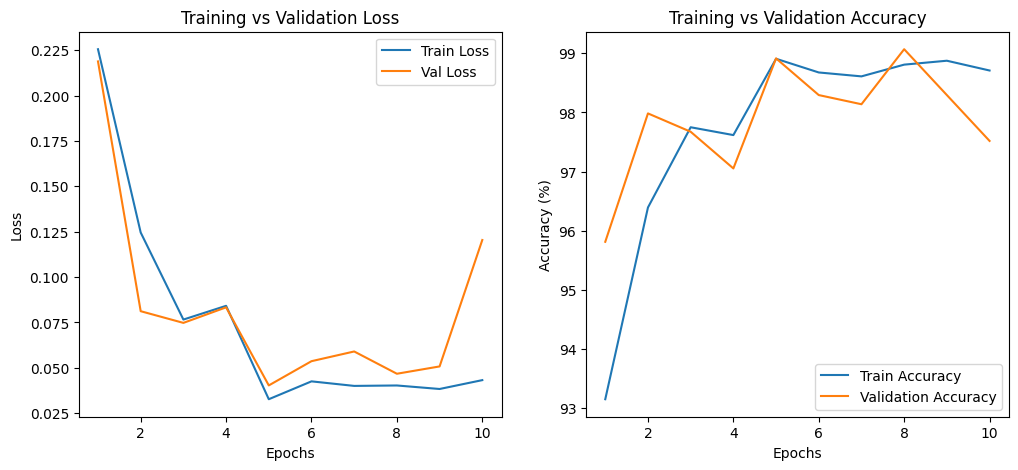

In [32]:
import json

# If you already saved history.json, load it back
with open("../logs/history.json", "r") as f:
    history = json.load(f)

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12,5))

# Plot Loss
plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, history["train_acc"], label="Train Accuracy")
plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.show()


In [29]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm  

# Load best model
model.load_state_dict(torch.load("../model/best_model.pth", map_location=device))  # ⚠️ check folder name: models not model
model.eval()

# Test DataLoader (same transforms as before)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder("../data_split_augmented/test", transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate with tqdm
correct, total = 0, 0
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing", unit="batch"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"\n✅ Test Accuracy: {100. * correct / total:.2f}%")


Testing: 100%|██████████| 71/71 [00:49<00:00,  1.44batch/s]


✅ Test Accuracy: 95.86%


✅ Predicted class: Ruddy Shelduck


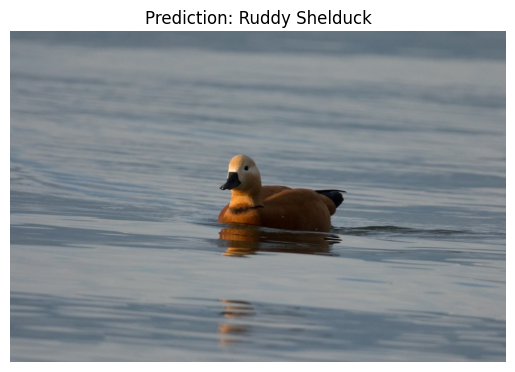

In [ ]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# ---------- Load the best model ----------
model.load_state_dict(torch.load("../model/best_model.pth", map_location=device))
model.eval()

# ---------- Define same test transform ----------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ---------- Load single image ----------
img_path = "../data_split_augmented/test/Ruddy Shelduck/ML52949551_hflip.jpg"   # put your image path here
img = Image.open(img_path).convert("RGB")

# Apply transform
img_tensor = transform(img).unsqueeze(0).to(device)  # add batch dimension

# ---------- Predict ----------
with torch.no_grad():
    outputs = model(img_tensor)
    _, predicted = outputs.max(1)

# Class names from dataset
class_names = test_dataset.classes

print(f"✅ Predicted class: {class_names[predicted.item()]}")

# ---------- Show image with prediction ----------
plt.imshow(img)
plt.title(f"Prediction: {class_names[predicted.item()]}")
plt.axis("off")
plt.show()


📊 Classification Report:
                       precision    recall  f1-score   support

Asian Green Bee-Eater       0.98      0.93      0.95       485
         Cattle Egret       0.99      0.95      0.97       482
         Gray Wagtail       0.89      0.97      0.93       486
         Indian Pitta       0.95      0.95      0.95       330
       Ruddy Shelduck       0.98      0.99      0.99       486

             accuracy                           0.96      2269
            macro avg       0.96      0.96      0.96      2269
         weighted avg       0.96      0.96      0.96      2269



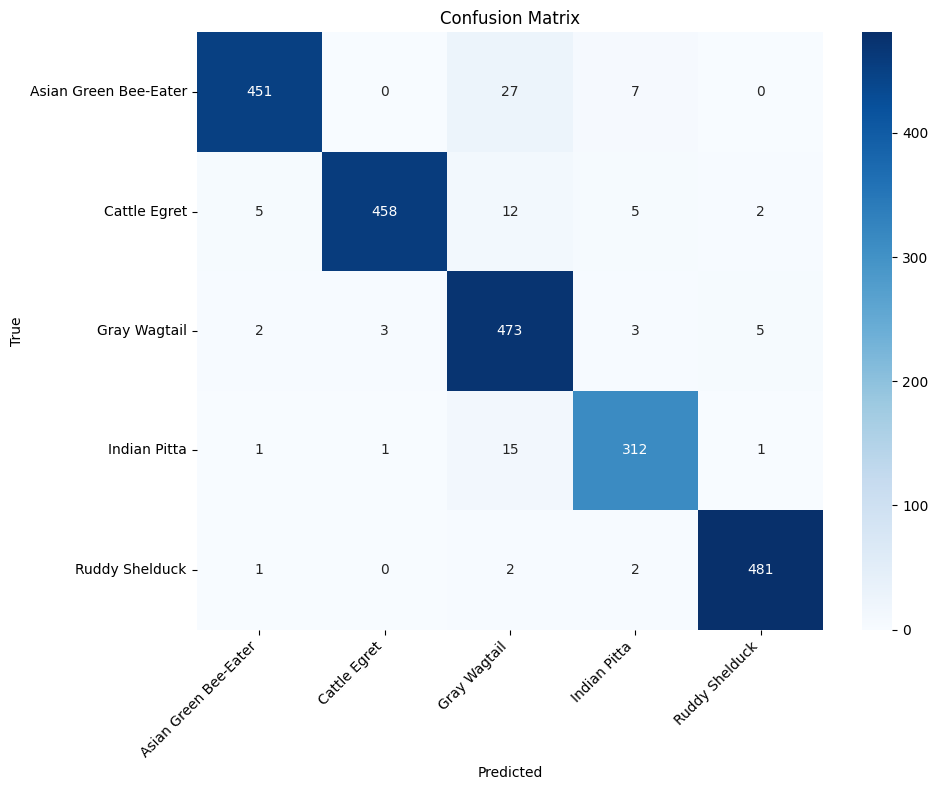

In [31]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Collect predictions & labels ----------
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# ---------- Classification Report ----------
class_names = test_dataset.classes
print("📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# ---------- Confusion Matrix ----------
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
